# Gesture Recognition

In this project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [4]:
import numpy as np
import os
import imageio
from skimage.io import imread
from skimage.transform import resize
from skimage.transform import resize, rescale
import datetime
import os
import tensorflow as tf
import matplotlib.pyplot as plt
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

We set the random seed so that the results don't vary drastically.

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
folder_path="/kaggle/input/project-data1/Project_data/"

In [6]:
train_doc = np.random.permutation(open(folder_path+'train.csv').readlines())
val_doc = np.random.permutation(open(folder_path+'val.csv').readlines())
num_classes = 5  #number of softmax classes

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = folder_path+'train'
val_path = folder_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Common Utility

Common utility to plot loss and accuracy

In [8]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Common utility to calculate steps

In [9]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

Common utility for callbacks

In [10]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]    

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(
/tmp/ipykernel_32/490613900.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread(folder_path+"val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
/tmp/ipykernel_32/490613900.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(folder_path+"val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_

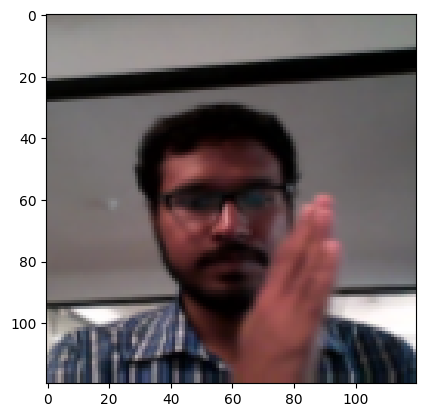

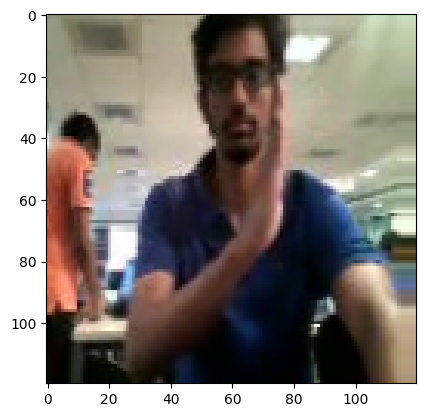

In [11]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread(folder_path+"val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
#160 by 120
image2 = imageio.imread(folder_path+"val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()
## Test code end

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

### Convolutional 3D Models

In [14]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

### Model 1

- 30 frames per video 
- (16, 32, 64, 128) filters
- conv 3D layers 
- 256 dense layer 
- 128 dense layer
- image size : 120 by 120


In [21]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [22]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [23]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_32/2636822326.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_32/300689100.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
66/67 [============================>.] - ETA: 2s - loss: 1.5574 - categorical_accuracy: 0.4424

/tmp/ipykernel_32/300689100.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5531 - categorical_accuracy: 0.4449
Epoch 1: val_loss improved from inf to 2.93810, saving model to model_conv3D_1_2023-11-0514_52_37.489401/model-00001-1.55305-0.44495-2.93810-0.23000.h5
67/67 [==============================] - 220s 3s/step - loss: 1.5531 - categorical_accuracy: 0.4449 - val_loss: 2.9381 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.1297 - categorical_accuracy: 0.5475
Epoch 2: val_loss did not improve from 2.93810
67/67 [==============================] - 211s 3s/step - loss: 1.1297 - categorical_accuracy: 0.5475 - val_loss: 3.9517 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.9665 - categorical_accuracy: 0.6259
Epoch 3: val_loss improved from 2.93810 to 2.91424, saving model to model_conv3D_1_2023-11-0514_52_37.489401/model-00003-0.96649-0.62594-2.91424-0.27000.h5
67/6

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


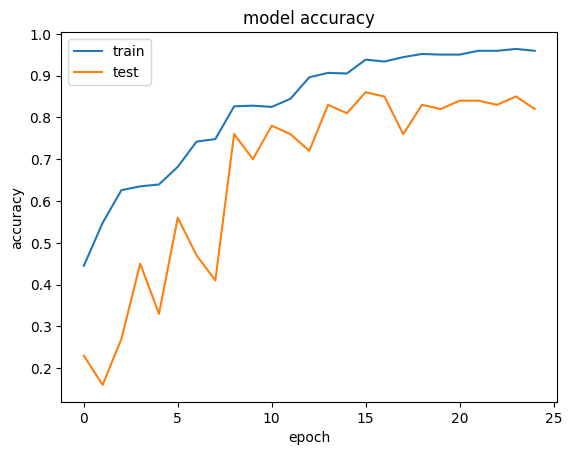

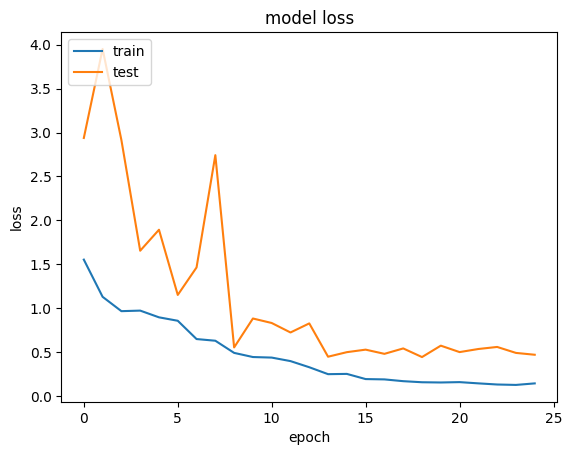

In [24]:
plot_loss_accuracy(history)

### Model 2

- 20 frames per video 
- (16, 32, 64, 128) filters
- conv 3D layers 
- 256 dense layer 
- 128 dense layer 
- image size 120 by 120

In [25]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activat

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [26]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [27]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_32/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_32/300689100.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
66/67 [============================>.] - ETA: 1s - loss: 1.6288 - categorical_accuracy: 0.4424

/tmp/ipykernel_32/300689100.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.6361 - categorical_accuracy: 0.4419
Epoch 1: val_loss improved from inf to 5.50559, saving model to model_conv3D_2_2023-11-0514_52_37.489401/model-00001-1.63611-0.44193-5.50559-0.21000.h5
67/67 [==============================] - 141s 2s/step - loss: 1.6361 - categorical_accuracy: 0.4419 - val_loss: 5.5056 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2719 - categorical_accuracy: 0.4962
Epoch 2: val_loss did not improve from 5.50559
67/67 [==============================] - 141s 2s/step - loss: 1.2719 - categorical_accuracy: 0.4962 - val_loss: 9.2512 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0632 - categorical_accuracy: 0.6199
Epoch 3: val_loss did not improve from 5.50559
67/67 [==============================] - 140s 2s/step - loss: 1.0632 - categorical_accuracy: 0.6199 - val_loss: 7

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


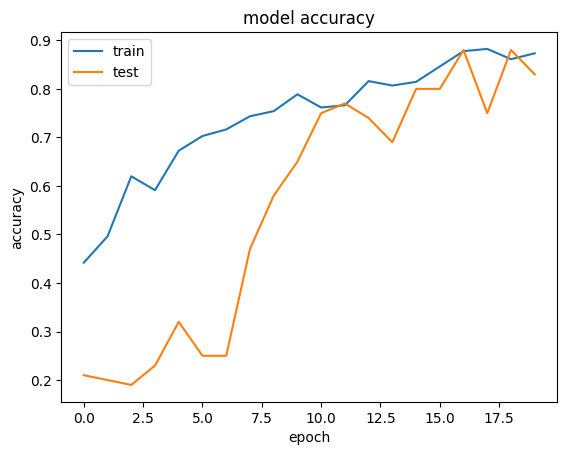

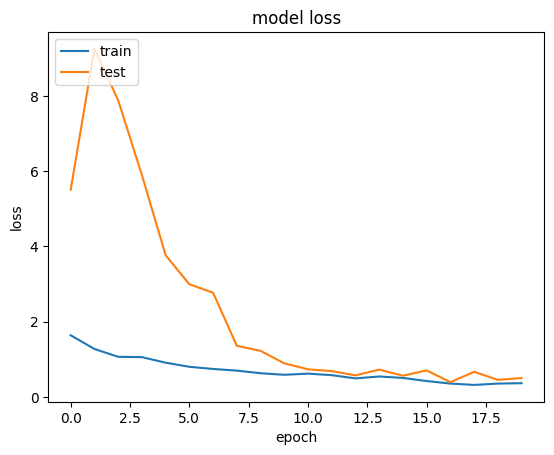

In [28]:
plot_loss_accuracy(history)

### Model 3

- 30 frames per video 
- (16, 32, 64, 128) filters
- conv 3D layers 
- 256 dense layer 
- 128 dense layer 
- image size 160 by 160

In [29]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_21 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 80, 80, 32)    13856     
                                                            

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [30]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [31]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_32/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_32/300689100.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 7s - loss: 1.5897 - categorical_accuracy: 0.4569 

/tmp/ipykernel_32/300689100.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5810 - categorical_accuracy: 0.4600
Epoch 1: val_loss improved from inf to 3.39346, saving model to model_conv3D_3_2023-11-0514_52_37.489401/model-00001-1.58102-0.46003-3.39346-0.17000.h5
67/67 [==============================] - 284s 4s/step - loss: 1.5810 - categorical_accuracy: 0.4600 - val_loss: 3.3935 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.4522 - categorical_accuracy: 0.4555
Epoch 2: val_loss did not improve from 3.39346
67/67 [==============================] - 267s 4s/step - loss: 1.4522 - categorical_accuracy: 0.4555 - val_loss: 3.6448 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1750 - categorical_accuracy: 0.5671
Epoch 3: val_loss improved from 3.39346 to 2.82175, saving model to model_conv3D_3_2023-11-0514_52_37.489401/model-00003-1.17502-0.56712-2.82175-0.31000.h5
67/6

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


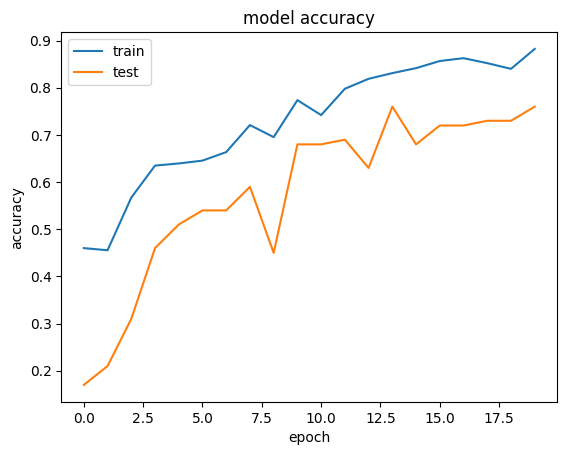

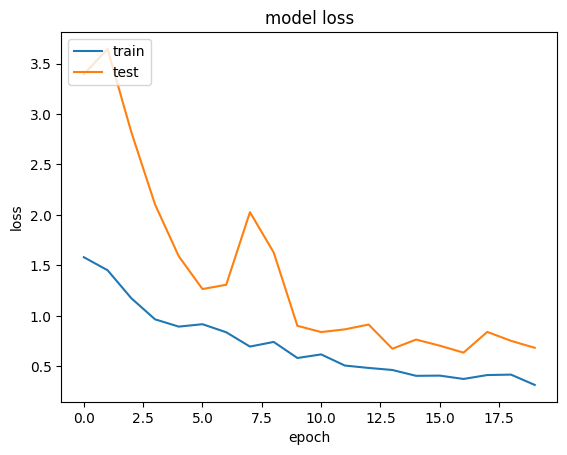

In [32]:
plot_loss_accuracy(history)

### Model 4

- 20 frames per video
- (16, 32, 64, 128 filters
- Conv 3D layers
- 256 dense layer 
- 128 dense layer 
- image size 160 by 160

In [15]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                              

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [17]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_33/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_33/300689100.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
66/67 [============================>.] - ETA: 3s - loss: 1.5447 - categorical_accuracy: 0.4273

/tmp/ipykernel_33/300689100.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5515 - categorical_accuracy: 0.4253
Epoch 1: val_loss improved from inf to 5.03820, saving model to model_conv3D_4_2023-11-0603_56_42.650067/model-00001-1.55148-0.42534-5.03820-0.16000.h5
67/67 [==============================] - 261s 4s/step - loss: 1.5515 - categorical_accuracy: 0.4253 - val_loss: 5.0382 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1352 - categorical_accuracy: 0.5897
Epoch 2: val_loss did not improve from 5.03820
67/67 [==============================] - 198s 3s/step - loss: 1.1352 - categorical_accuracy: 0.5897 - val_loss: 7.5601 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8756 - categorical_accuracy: 0.6863
Epoch 3: val_loss did not improve from 5.03820
67/67 [==============================] - 202s 3s/step - loss: 0.8756 - categorical_accuracy: 0.6863 - val_loss: 6

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


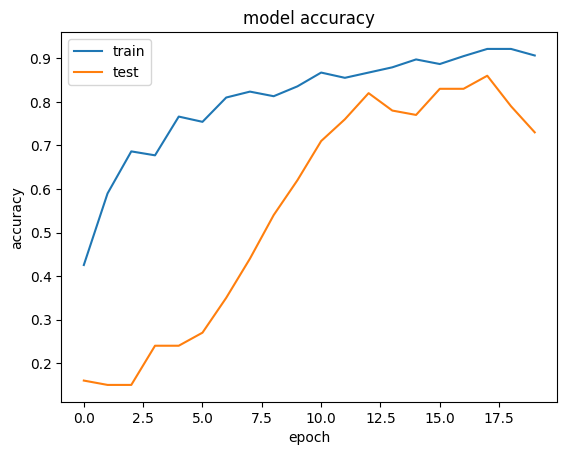

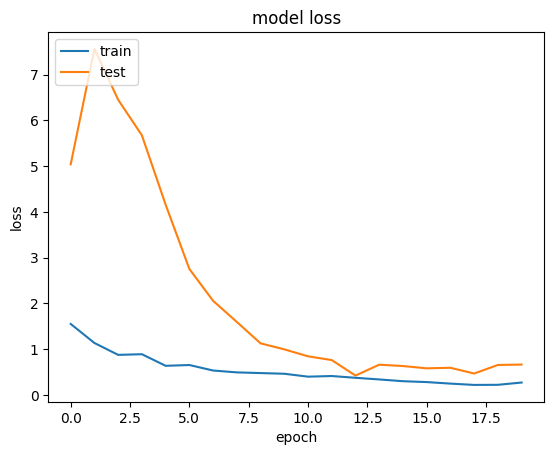

In [18]:
plot_loss_accuracy(history)

### Model 5

- 30 frames per video 
- (16, 32, 64, 128) filters 
- Conv 3D layers 
- 256 dense layer 
- 128 dense layer 
- Random data transformations on training data set

In [19]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15

# batch size = 10

# num_frames per video = 30

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv3d_9 (Conv3D)            (None, 30, 120, 120, 16)  1312      

_________________________________________________________________

activation_15 (Activation)   (None, 30, 120, 120, 16)  0         

_________________________________________________________________

batch_normalization_13 (Batc (None, 30, 120, 120, 16)  64        

_________________________________________________________________

max_pooling3d_9 (MaxPooling3 (None, 15, 60, 60, 16)    0         

_________________________________________________________________

conv3d_10 (Conv3D)           (None, 15, 60, 60, 32)    13856     

_________________________________________________________________

activation_16 (Activation)   (None, 15, 60, 60, 32)    0         

_________________________________________________________________

In [20]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [21]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.

  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 195s 3s/step - loss: 1.7452 - categorical_accuracy: 0.3792 - val_loss: 2.6609 - val_categorical_accuracy: 0.3500



Epoch 00001: val_loss improved from inf to 2.66091, saving model to model_conv3D_5_2020-08-1714_02_41.746177/model-00001-1.73287-0.38311-2.66091-0.35000.h5

Epoch 2/15

67/67 [==============================] - 205s 3s/step - loss: 1.4684 - categorical_accuracy: 0.4428 - val_loss: 3.1332 - val_categorical_accuracy: 0.3300



Epoch 00002: val_loss did not improve from 2.66091

Epoch 3/15

67/67 [==============================] - 204s 3s/step - loss: 1.3028 - categorical_accuracy: 0.4931 - val_loss: 1.7819 - val_categorical_accuracy: 0.4600



Epoch 00003: val_loss improved from 2.66091 to 1.78193, saving model to model_conv3D_5_2020-08-1714_02_41.746177/model-00003-1.29350-0.49472-1.78193-0.46000.h5

Epoch 4/15

67/67 [==============================] - 206s 3s/step - loss: 1.4906 - categorical_accuracy: 0.4314 - val_loss: 1.5359 - va

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


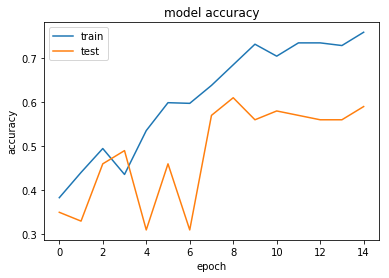

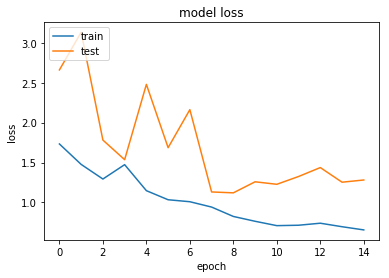

In [22]:
plot_loss_accuracy(history)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### TRANSFER LEARNING 

### MobileNet Conv2d and GRU

In [13]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

### Model 6

- Mobilenet (re train all weights) 
- GRU (128 cells) 
- 128 dense nodes

In [23]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
    

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [24]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [25]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_33/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_33/300689100.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 4s - loss: 1.1818 - categorical_accuracy: 0.5308

/tmp/ipykernel_33/300689100.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.1788 - categorical_accuracy: 0.5309
Epoch 1: val_loss improved from inf to 1.07492, saving model to model_retrain_mobilenet_gru_2023-11-0603_56_42.650067/model-00001-1.17878-0.53092-1.07492-0.49000.h5
67/67 [==============================] - 169s 2s/step - loss: 1.1788 - categorical_accuracy: 0.5309 - val_loss: 1.0749 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5256 - categorical_accuracy: 0.7994
Epoch 2: val_loss improved from 1.07492 to 0.64953, saving model to model_retrain_mobilenet_gru_2023-11-0603_56_42.650067/model-00002-0.52560-0.79940-0.64953-0.74000.h5
67/67 [==============================] - 162s 2s/step - loss: 0.5256 - categorical_accuracy: 0.7994 - val_loss: 0.6495 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3378 - categorical_accuracy: 0.8869
Epoch 3: val_loss improve

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


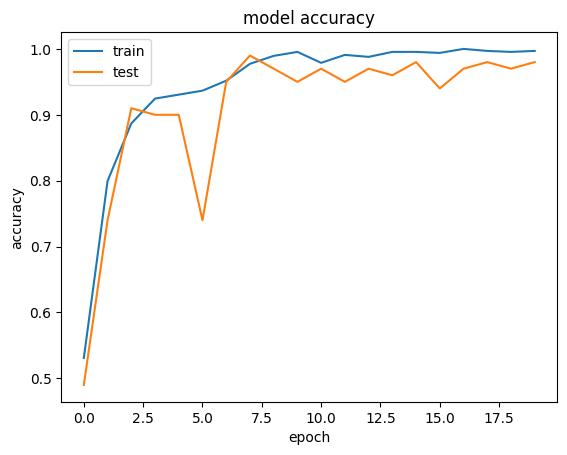

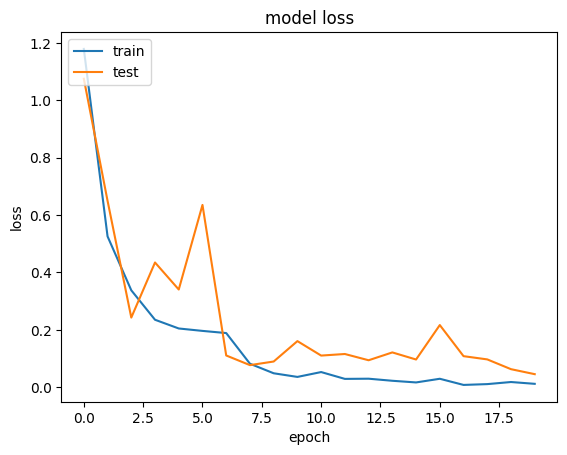

In [26]:
plot_loss_accuracy(history)

### Model 7

- Mobilenet (re train all weights) 
- GRU (128 cells)
- 128 dense nodes 
- Random data transformations on training data set

In [27]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
    

In [28]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [29]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_33/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_33/300689100.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 8s - loss: 1.1772 - categorical_accuracy: 0.5046 

/tmp/ipykernel_33/300689100.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.1789 - categorical_accuracy: 0.5038
Epoch 1: val_loss improved from inf to 0.78913, saving model to model_retrain_mobilenet_gru_2023-11-0603_56_42.650067/model-00001-1.17889-0.50377-0.78913-0.71000.h5
67/67 [==============================] - 329s 5s/step - loss: 1.1789 - categorical_accuracy: 0.5038 - val_loss: 0.7891 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6463 - categorical_accuracy: 0.7421
Epoch 2: val_loss improved from 0.78913 to 0.43658, saving model to model_retrain_mobilenet_gru_2023-11-0603_56_42.650067/model-00002-0.64634-0.74208-0.43658-0.85000.h5
67/67 [==============================] - 268s 4s/step - loss: 0.6463 - categorical_accuracy: 0.7421 - val_loss: 0.4366 - val_categorical_accuracy: 0.8500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4272 - categorical_accuracy: 0.8401
Epoch 3: val_loss did not

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


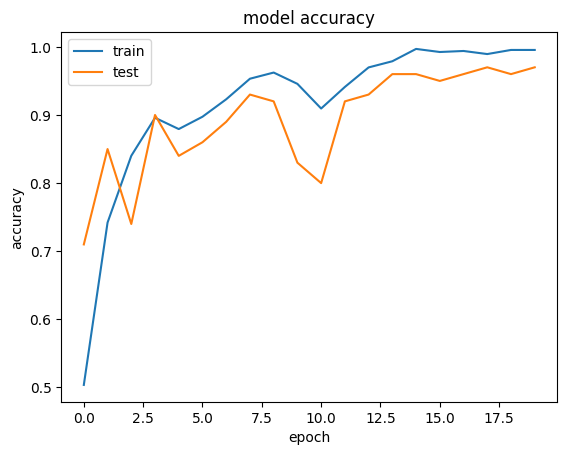

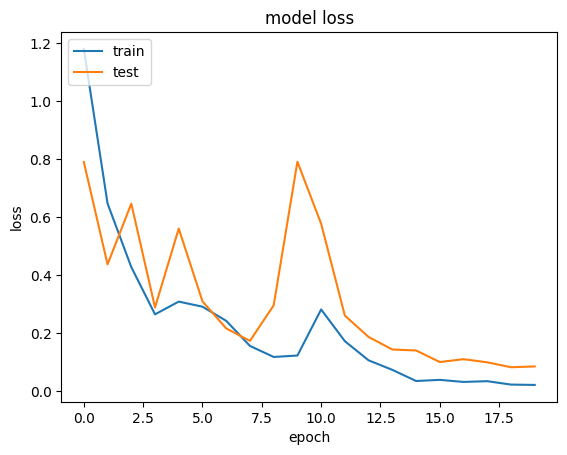

In [30]:
plot_loss_accuracy(history)

### Model 8

- Mobilenet (fine tune) 
- GRU (128 cells) 
- 128 dense nodes

In [31]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=True, gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [32]:
callbacks_list = model_callbacks("model_finetune_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [33]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_33/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_33/300689100.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 4s - loss: 1.2127 - categorical_accuracy: 0.5062

/tmp/ipykernel_33/300689100.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2021 - categorical_accuracy: 0.5113
Epoch 1: val_loss improved from inf to 1.01606, saving model to model_finetune_mobilenet_gru_2023-11-0603_56_42.650067/model-00001-1.20206-0.51131-1.01606-0.53000.h5
67/67 [==============================] - 171s 3s/step - loss: 1.2021 - categorical_accuracy: 0.5113 - val_loss: 1.0161 - val_categorical_accuracy: 0.5300 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5315 - categorical_accuracy: 0.7798
Epoch 2: val_loss improved from 1.01606 to 0.53402, saving model to model_finetune_mobilenet_gru_2023-11-0603_56_42.650067/model-00002-0.53150-0.77979-0.53402-0.82000.h5
67/67 [==============================] - 162s 2s/step - loss: 0.5315 - categorical_accuracy: 0.7798 - val_loss: 0.5340 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3652 - categorical_accuracy: 0.8748
Epoch 3: val_loss impro

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


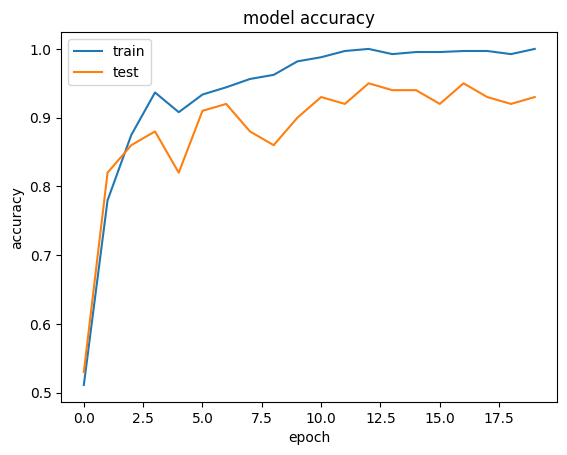

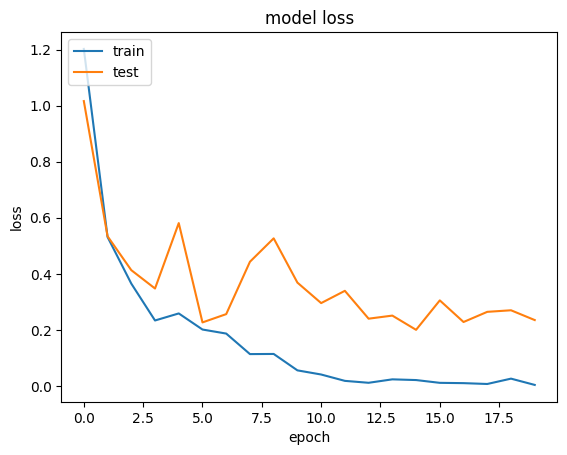

In [34]:
plot_loss_accuracy(history)

### Model 9

 - Mobilenet (re train all wieghts) 
 - LSTM (128 cells) 
 - 128 dense nodes




In [35]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [36]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [37]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_33/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_33/300689100.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 4s - loss: 1.2886 - categorical_accuracy: 0.4600

/tmp/ipykernel_33/300689100.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2800 - categorical_accuracy: 0.4630
Epoch 1: val_loss improved from inf to 0.84360, saving model to model_retrain_mobilenet_lstm_2023-11-0603_56_42.650067/model-00001-1.28004-0.46305-0.84360-0.65000.h5
67/67 [==============================] - 170s 2s/step - loss: 1.2800 - categorical_accuracy: 0.4630 - val_loss: 0.8436 - val_categorical_accuracy: 0.6500 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.7081 - categorical_accuracy: 0.7436
Epoch 2: val_loss improved from 0.84360 to 0.60589, saving model to model_retrain_mobilenet_lstm_2023-11-0603_56_42.650067/model-00002-0.70808-0.74359-0.60589-0.77000.h5
67/67 [==============================] - 162s 2s/step - loss: 0.7081 - categorical_accuracy: 0.7436 - val_loss: 0.6059 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.6549 - categorical_accuracy: 0.7738
Epoch 3: val_loss did n

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


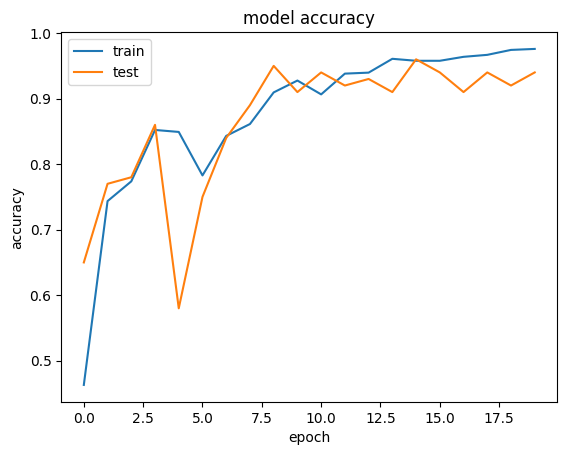

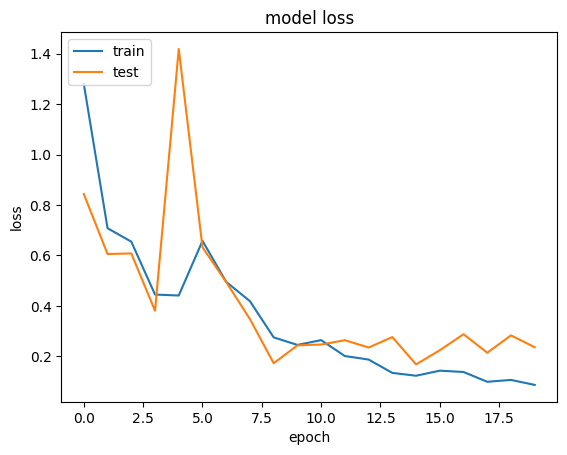

In [38]:
plot_loss_accuracy(history)

### Model 10(Final Model)

- Mobilenet (re train all weights) 
- 64 dense nodes

In [14]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=True, num_images=num_frames, lstm_gru_cells=128, dense_nodes=64)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
17225924/17225924 [==============================] - 0s 0us/step
Number of layers in the pretrained mobilenet model:  86
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 tribut

In [15]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_64")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [16]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_32/4147385776.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_32/490613900.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 6s - loss: 1.3641 - categorical_accuracy: 0.4523

/tmp/ipykernel_32/490613900.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.3563 - categorical_accuracy: 0.4555
Epoch 1: val_loss improved from inf to 0.93411, saving model to model_retrain_mobilenet_gru_64_2023-11-0616_51_17.626802/model-00001-1.35625-0.45551-0.93411-0.60000.h5
67/67 [==============================] - 254s 4s/step - loss: 1.3563 - categorical_accuracy: 0.4555 - val_loss: 0.9341 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.7048 - categorical_accuracy: 0.7421
Epoch 2: val_loss improved from 0.93411 to 0.65108, saving model to model_retrain_mobilenet_gru_64_2023-11-0616_51_17.626802/model-00002-0.70476-0.74208-0.65108-0.68000.h5
67/67 [==============================] - 144s 2s/step - loss: 0.7048 - categorical_accuracy: 0.7421 - val_loss: 0.6511 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4547 - categorical_accuracy: 0.8446
Epoch 3: val_loss i

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


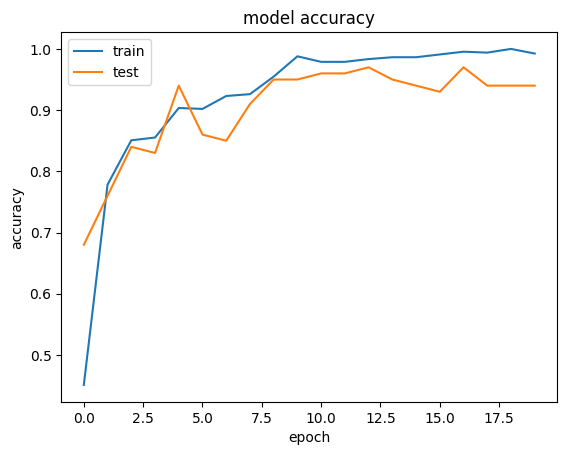

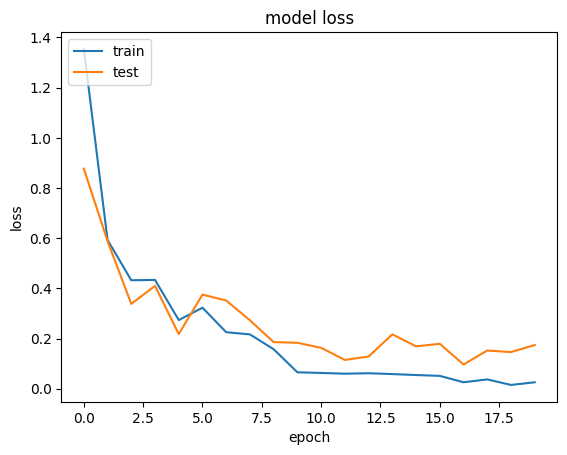

In [42]:
plot_loss_accuracy(history)
